IMPORTING LIBRARIES

In [23]:
# importing libraries
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics

LOAD DATA

In [24]:
# Loading data
data = pd.read_csv('C:/Users/User/Downloads/spam.csv', encoding = 'latin1')
styled_data = data.head()
styled_data = styled_data.style.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "#A6D5FF")]}
])
styled_data

    

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",nan,nan,nan
1,ham,Ok lar... Joking wif u oni...,nan,nan,nan
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,nan,nan,nan
3,ham,U dun say so early hor... U c already then say...,nan,nan,nan
4,ham,"Nah I don't think he goes to usf, he lives around here though",nan,nan,nan


In [25]:
# Dropping the redundant-looking columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)


In [26]:
styled_data = data.head(5).style
# Modify the color and background color of the table headers (th)
styled_data.set_table_styles([
    {"selector": "th", "props": [("color", 'Black'), ("background-color", "#A6D5FF"), ('font-weight', 'bold')]}
])

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


DATA EXPLORATION

In [27]:
# Check missing values
data.isnull().sum()

Target    0
Text      0
dtype: int64

In [28]:
#check duplicate values
data.duplicated().sum()

403

In [29]:
# remove Duplicate values
data = data.drop_duplicates(keep = 'first')

Text(0, 0.5, 'Number of Data points')

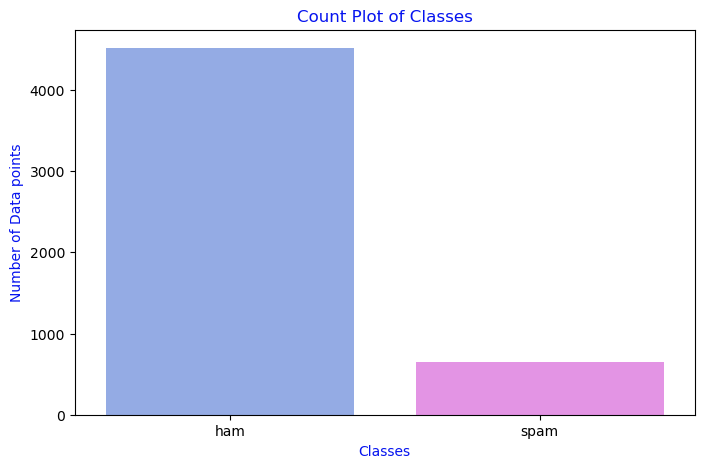

In [30]:
cols = ["#86A5F2", "#F086F2"]
# Controll if data is imbalanced or not
plt.figure(figsize=(8,5))
fg = sns.countplot(x='Target', hue='Target', data=data, palette=cols, legend=False)
fg.set_title("Count Plot of Classes", color= "#0513EF")
fg.set_xlabel("Classes", color= "#0513EF")
fg.set_ylabel("Number of Data points", color= "#0513EF")


In [31]:
# Add a column of numbers of characters, words, and sentences in each message.
# We tokenized the words and sentences and used the length of the same.
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"] = data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_Sentence"]= data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,910.0
No_of_Words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,220.0
No_of_Sentence,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,38.0


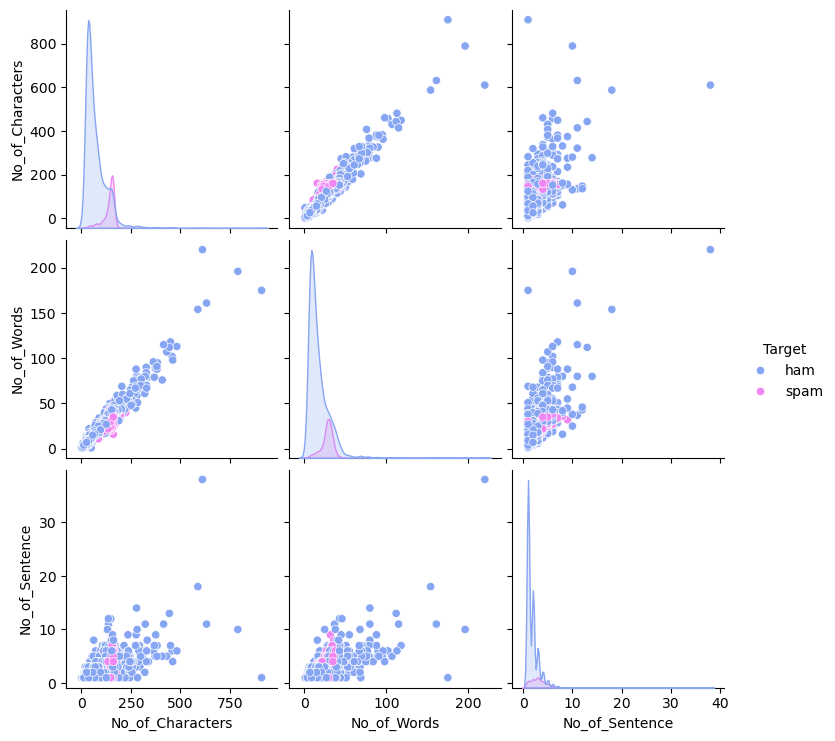

In [32]:
# create the pairplot
fg = sns.pairplot(data=data, hue="Target", palette=cols, height=2.5)  # Adjust height as needed
plt.show()

In [33]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(5149, 5)

CLEAN TEXT

In [34]:
# Sample of 5 first texts before cleaning process
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [35]:
data = data.copy()

# Define the Clean function
def Clean(Text):
    import re
    sms = re.sub('[^a-zA-Z]', ' ', Text)  # Replacing all non-alphabetic characters with a space
    sms = sms.lower()  # Converting to lowercase
    sms = sms.split()  # Splitting into words
    sms = ' '.join(sms)  # Joining back into a single string
    return sms

# Fill NaN values with an empty string
data.loc[:, 'Text'] = data['Text'].fillna('')

# Apply the Clean function
data.loc[:, "Clean_Text"] = data["Text"].apply(Clean)

# Display the DataFrame
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")


 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


TOKENIZATION

In [36]:

# Apply tokenization
data.loc[:, "Tokenize_Text"] = data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

# Print the first 5 tokenized texts
print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m", *data["Tokenize_Text"][:5], sep="\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


REMOVE STOPWORDS

In [37]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


LEMMATIZER

In [38]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


VECTORIZE

In [39]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [40]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [41]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

MODEL BUILDING

In [42]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest",2: "SVC"}

In [44]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.962856 
RandomForest: 0.972325 
SVC: 0.972810 


MODEL EVALUATION

In [46]:
# Model Evaluation
# creating lists of various scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
      #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [47]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "SVC"])

In [48]:
cmap2 = ListedColormap(["#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.745614,0.854271,0.975728,0.997815
RandomForest,1.000000,0.824561,0.903846,0.975728,0.997815
SVC,0.978495,0.798246,0.879227,0.975728,0.997815


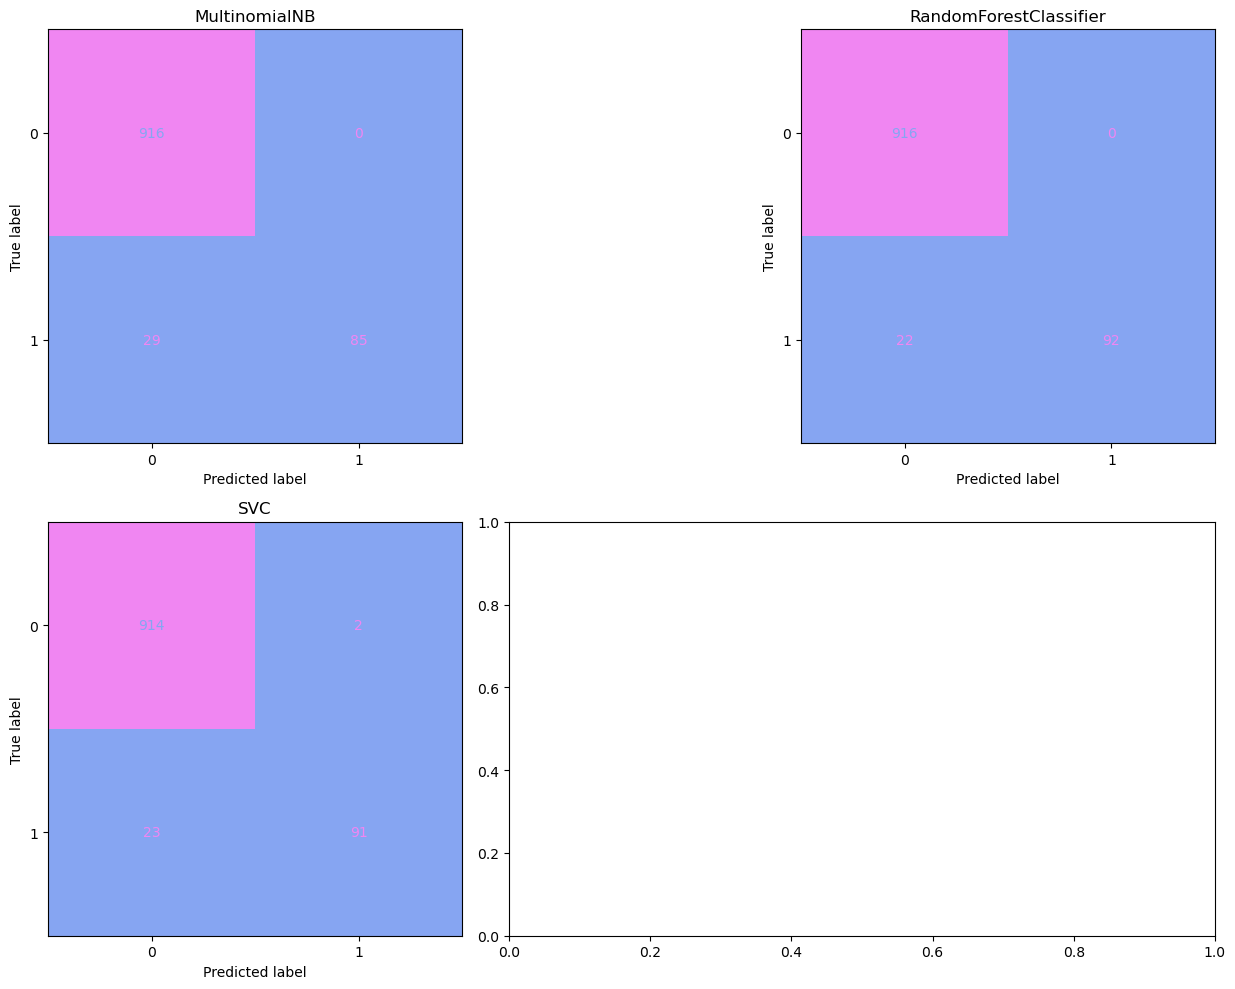

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

cmap = ListedColormap(["#86A5F2", "#F086F2"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)  # Make sure to fit the classifier
    disp = ConfusionMatrixDisplay.from_estimator(cls, X_test, y_test, ax=ax, cmap=cmap)
    disp.im_.colorbar.remove() 
    ax.set_title(type(cls).__name__)

plt.tight_layout()
plt.show()
